# Black-Scholes Option Pricing using the Thomas Algorithm

This notebook implements a numerical solution to the Black-Scholes partial differential equation (PDE) for pricing a European call option. The solution uses the implicit finite difference method with the Thomas algorithm (tridiagonal matrix algorithm) to solve the resulting system of linear equations.

## Problem Description
- We aim to price a European call option with a strike price `K`, volatility `volatility`, risk-free rate `r`, and time to maturity `T`.
- The spatial domain (`x`) represents the underlying asset price, discretized non-uniformly.
- The temporal domain (`t`) is discretized into `Nt` time steps.
- The Thomas algorithm is used to efficiently solve the tridiagonal system at each time step.

## Key Parameters
- `K`: Strike price of the option (default: 100)
- `volatility`: Volatility of the underlying asset (default: 0.3)
- `r`: Risk-free interest rate (default: 0.03)
- `T`: Time to maturity in years (default: 1)
- `Nt`: Number of time steps (default: 360)
- `x`: Grid of underlying asset prices (non-uniform)

## Methodology
1. **Grid Setup**: Define a non-uniform spatial grid `x` and compute step sizes `h`.
2. **Initial Condition**: Set the payoff at maturity as `max(x - K, 0)` for a call option.
3. **Finite Difference Scheme**: Use an implicit scheme to discretize the Black-Scholes PDE.
4. **Thomas Algorithm**: Solve the tridiagonal system at each time step to compute option prices.
5. **Visualization**: Plot the payoff and final option price, highlighting the price at `x = 100`.

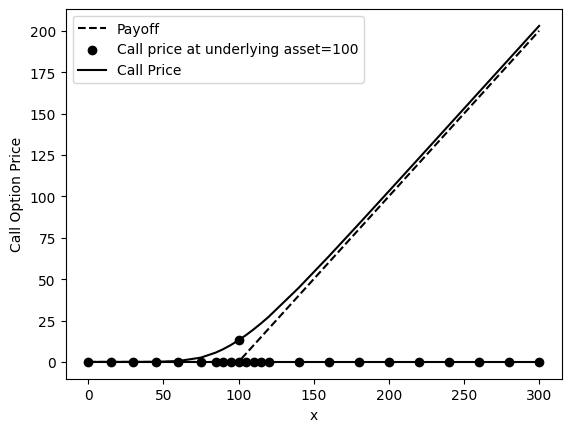

Price=13.069568


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def thomas(alpha, beta, gamma, f):
    """
    Solves a tridiagonal system using the Thomas algorithm.
    
    Parameters:
    alpha: Lower diagonal elements (length n)
    beta : Main diagonal elements (length n)
    gamma: Upper diagonal elements (length n)
    f    : Right-hand side vector (length n)
    
    Returns:
    v    : Solution vector (length n)
    """
    n = len(f)
    v = np.zeros(n, dtype=float)
    
    # Copy input arrays to avoid modifying originals
    alpha = np.array(alpha, dtype=float)
    beta = np.array(beta, dtype=float)
    gamma = np.array(gamma, dtype=float)
    f = np.array(f, dtype=float)

    # Forward Elimination phase
    for i in range(1, n):
        mult = alpha[i] / beta[i - 1]
        beta[i] = beta[i] - mult * gamma[i - 1]
        f[i] = f[i] - mult * f[i - 1]

    # Back Substitution phase
    v[n - 1] = f[n - 1] / beta[n - 1]
    for i in range(n - 2, -1, -1):
        v[i] = (f[i] - gamma[i] * v[i + 1]) / beta[i]

    return v

# Define parameters
K = 100              # Strike price
volatility = 0.3     # Volatility of the underlying asset
r = 0.03             # Risk-free interest rate
T = 1                # Time to maturity (in years)
Nt = 360             # Number of time steps
dt = T / Nt          # Time step size

# Define spatial grid (non-uniform)
A = np.arange(0, 80, 15)      # Low range: 0 to 75 with step 15
B = np.arange(85, 125, 5)     # Mid range: 85 to 120 with step 5
C = np.arange(140, 320, 20)   # High range: 140 to 300 with step 20
x = np.r_[A, B, C]            # Concatenate all ranges into one grid
h = np.diff(x)                # Compute spatial step sizes
h = np.r_[h[0], h, h[-1]]     # Extend step sizes for boundary conditions
Nx = len(x)                   # Number of spatial grid points

# Initialize solution array: rows = spatial points, columns = time steps
u = np.zeros([Nx, Nt + 1])
u[:, 0] = np.maximum(x - K, 0)  # Initial condition: payoff at maturity

# Plot the initial payoff
plt.plot(x, u[:, 0], 'k--', label='Payoff')

# Initialize tridiagonal matrix coefficients
[a, d, c, b] = map(np.zeros, [Nx-1, Nx-1, Nx-1, Nx-1])

# Set up coefficients for the implicit finite difference scheme
a[:] = (-volatility**2 * x[1:Nx]**2 + r * x[1:Nx] * h[2:Nx+1]) / (h[1:Nx] * (h[1:Nx] + h[2:Nx+1]))
d[:] = (volatility**2 * x[1:Nx]**2 - r * x[1:Nx] * (h[2:Nx+1] - h[1:Nx])) / (h[1:Nx] * h[2:Nx+1]) + r + 1/dt
c[:] = (-volatility**2 * x[1:Nx]**2 - r * x[1:Nx] * h[1:Nx]) / (h[2:Nx+1] * (h[1:Nx] + h[2:Nx+1]))

# Apply boundary condition adjustments
a[Nx-2] = a[Nx-2] - c[Nx-2]
d[Nx-2] = d[Nx-2] + 2 * c[Nx-2]

# Time-stepping loop
for n in range(0, Nt):
    b = u[1:Nx, n] / dt          # Right-hand side for current time step
    u[1:Nx, n+1] = thomas(a, d, c, b)  # Solve using Thomas algorithm

# Find index where underlying asset price is 100
ii = np.where(x == 100)

# Plot results
plt.scatter(x[ii], u[ii, Nt], color='k', label='Call price at underlying asset=100')
plt.plot(x, u[:, Nt], 'k-', label='Call Price')  # Final option price
plt.plot(x, 0 * u[:, Nt], 'ko-')                # Zero line for reference
plt.xlabel('x', fontsize=10)                    # X-axis label
plt.ylabel('Call Option Price', fontsize=10)    # Y-axis label
plt.legend(loc='upper left')                    # Add legend
plt.show()

# Print the option price at x = 100
print('Price=%f' % u[ii, Nt].item())